1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [27]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import pylab
from scipy import stats
import scipy.optimize as opt
from scipy.optimize import fmin
import scipy
import pandas as pd


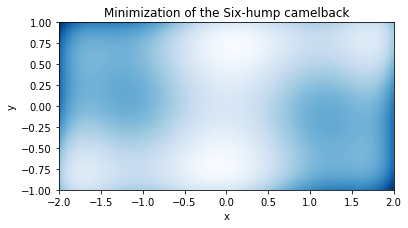

The solutions are:

f( [-0.08984141  0.71265608] ) =  -1.0316284534877955
f( [-0.08984207  0.71265639] ) =  -1.031628453489864

For the initial guess of (x,y) =(0,0)
f( [0. 0.] ) =  0.0
(x,y)=(0,0) should not be used since the result is 0.0 which is not a global minima


In [28]:
def fun(x_y):
    x,y=x_y
    return (4-(2.1)*((x)**2)+((x**4)/3))*(x**2)+(x*y)+((4*(y**2)-4)*y**2)

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
vx,vy =np.meshgrid(x,y)

fig, ax = plt.subplots()
x_y = (vx,vy)
pos = ax.imshow(fun(x_y),  extent=[-2,2,-1,1], cmap='Blues')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Minimization of the Six-hump camelback')
plt.show()


starts = [(-2,2), (-1,1)]
#The global minimas
print("The solutions are:\n")
for point in starts:
    results = optimize.minimize(fun, point)
    if results.success:
        print('f(',results.x,') = ', fun(results.x))

#For the case of (0,0)
print("\nFor the initial guess of (x,y) =(0,0)")
results = optimize.minimize(fun, (0, 0))
if results.success:
    print('f(',results.x,') = ', fun(results.x))
    
print("(x,y)=(0,0) should not be used since the result is 0.0 which is not a global minima")


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

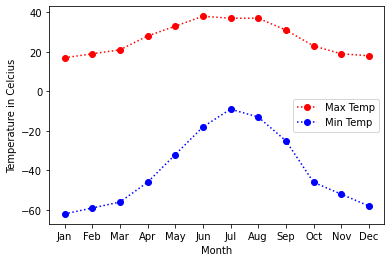

In [29]:
max_temp=np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

#plotting the temperatures

months = ['Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug','Sep', 'Oct', 'Nov', 'Dec']
x = np.linspace(1, 12, 12)
fig, ax = plt.subplots(1,1)
ax.plot_date(x, max_temp, linestyle='dotted', label="Max Temp",color='red')
ax.plot_date(x, min_temp, linestyle='dotted', label="Min Temp",color='blue')
ax.set_xticks(x)
ax.set_xticklabels(months)
plt.xlabel("Month")
plt.ylabel("Temperature in Celcius")
plt.legend()
plt.show()


because of the form of the plotim using the gaussian distribution function
[52.64929237 38.67906268  7.16452592 -1.97590021] 

[[ 1.96936534e+00 -1.05130826e+00 -8.73514507e-04 -2.27189346e-02]
 [-1.05130826e+00  1.41331296e+00  1.09103145e-03  7.06522799e-02]
 [-8.73514507e-04  1.09103145e-03  2.22850172e-03  4.92560422e-05]
 [-2.27189346e-02  7.06522799e-02  4.92560422e-05  5.77329045e-03]] 

[23.09206756 15.77935157  6.73581538 -2.29443058] 

[[ 1.32869077e+00 -1.08342975e+00 -1.60429545e-03 -1.01482890e-01]
 [-1.08342975e+00  1.38436071e+00  1.91654692e-03  1.70938245e-01]
 [-1.60429545e-03  1.91654692e-03  6.31514933e-03  2.12239950e-04]
 [-1.01482890e-01  1.70938245e-01  2.12239950e-04  2.75444997e-02]] 



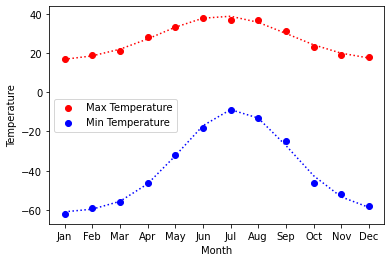

In [31]:
print("because of the form of the plotim using the gaussian distribution function")
def gauss_fun(values, mean, std, offset, sigma):
    return mean*np.exp(-(values-offset)**2/(2*sigma**2)) + std

par_min,par_min_covariance = opt.curve_fit(gauss_fun, x, min_temp+100)
par_max,par_max_covariance = opt.curve_fit(gauss_fun, x, max_temp)

print(par_min,'\n')
print (par_min_covariance,'\n')
print(par_max,'\n')
print (par_max_covariance,'\n')

fig, ax = plt.subplots(1,1)
ax.plot(x,gauss_fun(x, par_max[0], par_max[1], par_max[2], par_max[3]), color='red',linestyle='dotted')
ax.scatter(x,max_temp,label="Max Temperature",color='red')
ax.scatter(x,min_temp,label="Min Temperature",color='blue')
ax.plot(x,gauss_fun(x, par_min[0], par_min[1], par_min[2], par_min[3])-100,color='blue',linestyle='dotted')
ax.set_xticks(x)
ax.set_xticklabels(months)
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.legend()

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

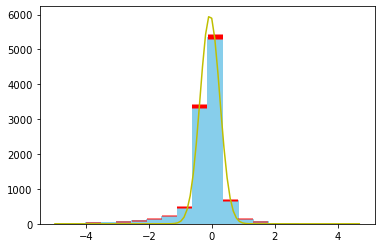

n degrees of freedom = 19
chi2 = 13859.400035557564
p-value :  0.0  of the fit is unsatisfactory


In [37]:
import pickle

filename = 'data/residuals_261.pkl'
s = open(filename, 'rb') 
new_dict = pickle.load(s)
s.close


a = np.load(filename, allow_pickle = True).item()
df = pd.DataFrame(a)

df = df[df['residuals']>-5] 
df = df[df['residuals']<5] 
data = df['residuals'] 
fig, ax = plt.subplots()
y, edges, _ = ax.hist(data, bins = 20, color = "skyblue", ec="skyblue") 

bincenters = 0.5*(edges[1:] + edges[:-1])
yerr = np.sqrt(np.abs(y))
ax.errorbar(bincenters, y, yerr, fmt='none',c='red', linewidth=15, capsize=0, barsabove=True)

#in this gaussian function there is no std
def gauss_fun2(x, scale, mean ,sigma):
    return scale*np.exp(-((x-mean)**2/(sigma**2)))


fit = optimize.curve_fit(gauss_fun2, bincenters, y, p0 = [1,1,1], maxfev=1000000)
x = np.linspace(edges[0], edges[-1], 100)
scale, mean, sigma = (fit[0])[0], (fit[0])[1], (fit[0])[2]
ax.plot(x, gaussiana(x, scale, mean, sigma), 'y')
plt.show()

#check for the  p-values
ndof = len(bincenters) - 1
print("n degrees of freedom =", ndof)

chi2 = np.sum(((y - gauss_fun2(bincenters, scale, mean, sigma))**2) / yerr)
print("chi2 =", chi2)
# calculate the p-value f
pvalue = 1. - stats.chi2.cdf(chi2, ndof)

#the fit is good only if the p-value is >0.05
if (pvalue<0.5):
    print("p-value : ", pvalue, " of the fit is unsatisfactory")
else:
    print("p-value : ", pvalue, " of the fit is satisfactory")

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

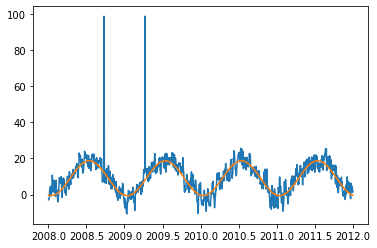

Best fit values:
f(x) = -9.67 cos(2πx 12.3) + 9.05
Average Temperature = 8.94190703859861
Coldest Predicted Temperature = -0.6187146855384551
Hottest Predicted Temperature = 18.723838890445855
Parameter b shifts the function horizontally, it stands for the initial phase of the cosine function

Fisher test:
CL: 0.634 , additional parameter necessary: NO


In [42]:
from scipy.stats import f

#Plot temperatures between the years 2008 and 2012
data = pd.read_csv('data/munich_temperatures_average_with_bad_data.txt', header=None, sep=' ', names=['Year', 'Temperature'])
fig, ax = plt.subplots()
ax.plot('Year', 'Temperature', data = data[(data['Year']>=2008) & (data['Year']<=2012)])

#Cosine formula
def f(x,a,b,c):
    return a*np.cos(2*np.pi*x + b) + c

fit, cov = optimize.curve_fit(f, data['Year'], data['Temperature'], p0 = [1,1,1], full_output=False)
a, b, c = fit[0], fit[1], fit[2]
data['Interpolation_f'] = f(data['Year'], a, b, c)
ax.plot('Year', 'Interpolation_f', data= data[(data['Year']>2008) & (data['Year']<2012)])
plt.show()

#Best-fit values
print('Best fit values:\nf(x) = {:.3} cos(2\u03C0x {:.3}) + {:.3}'.format(a,b,c))
#getting the coldest,average and hottest temperatures
print('Coldest Predicted Temperature =', c+a)
print('Average Temperature =', data['Temperature'].mean())
print('Hottest Predicted Temperature =', c-a)
print('Parameter b shifts the function horizontally, it stands for the initial phase of the cosine function')

#creating the formula
def g(x,a,b,c,d):
    return a*np.cos(2*np.pi*x*b +c)+d

#RSS for f(x) and g(x)
fit, cov = optimize.curve_fit(g, data['Year'], data['Temperature'], p0 = [1, 1, 1, 1], full_output=False)
a, b, c, d = fit[0], fit[1], fit[2], fit[3]
data['Interpolation_g']=g(data['Year'], a, b, c, d)


def Ftest(ssr_f, ssr_g, ndof_f, ndof_g, nbins, verbose=False):
    F = ((ssr_f - ssr_g)/(ndof_g - ndof_f)) / (ssr_g/(nbins - ndof_g))
    CL = 1. - stats.f.cdf(F, ndof_g - ndof_f, nbins - ndof_g)
    if verbose: print("CL: %.3f" % CL,", additional parameter necessary:", "YES" if CL < 0.10 else"NO")
    return CL

ssr_1 = np.sum((data['Temperature']-data['Interpolation_f'])**2)
ssr_2 = np.sum((data['Temperature']-data['Interpolation_g'])**2)
print('\nDoing the Fisher test:')
cl = Ftest(ssr_1, ssr_2, 3, 4, len(data.index), verbose=True)